In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Attribute mapping

## 1. Analysis

### 1.1 Project Description 

This project aims to develop a machine learning model capable of identifying grocery products and categorizing them based on their images. The model will analyze product images to classify items such as fruits, vegetables, beverages, and packaged goods into predefined categories. 

### 1.2 Business Objective Definition

Our solution aims to enhance Stibo Systems' Master Data Management (MDM) capabilities by integrating advanced image recognition technology to automatically identify and categorize customer products based on images provided by their clients. This innovation will streamline product classification processes, ensuring greater accuracy and efficiency. By empowering Stibo Systems to offer a more intelligent and automated approach to product data management, the solution supports practical use cases such as improved inventory management, retail automation, and enhanced consumer convenience, while also enabling applications like automatic checkout, product cataloging, and stock monitoring. 

### 1.3 Framing the problem
The problem is a supervised learning classification task, where the model takes a picture of a grocery item, identifies it and maps it into its category. Labeled datasets containing images and corresponding category labels are used to train the model. A classification model would seem like a good fit for classifying an image to the item’s name and category. 

The target audience includes Stibo Systems and their clients, who rely on accurate and automated product categorization for harmonizing data across multiple sources in their MDM-systems. While the initial focus is on grocery products, the ultimate goal is to develop a scalable solution that can extend to any product category, providing a versatile tool for data management needs. 


### 1.4 Performance Metrics 

In our project, we will evaluate the performance of the model using a combination of precision, recall, F1-score, and top-k accuracy to ensure a comprehensive assessment of its effectiveness in identifying and categorizing grocery products. 

- Precision will measure the proportion of correctly predicted products in each category out of all predictions for that category. This metric is essential to minimize false positives, ensuring that incorrect categorizations are kept to a minimum. 

- Recall will assess the proportion of correctly identified products in each category out of all actual products in that category. This is particularly important to ensure that the model does not miss relevant products, especially in scenarios where accurate categorization is critical for downstream processes. 

- F1-Score, the harmonic mean of precision and recall, will serve as the primary metric for overall model performance. It provides a balanced measure, particularly useful in scenarios where there is a need to optimize both precision and recall, such as handling imbalanced categories or avoiding bias toward dominant product types. 

- Top-k Accuracy will measure whether the correct category appears within the top-k predictions. This metric is particularly relevant for real-world applications like auto-checkout or cataloging, where the system can suggest multiple likely categories for verification, ensuring practical usability even when the top prediction is incorrect. 

By combining these metrics, we will gain a holistic understanding of the model’s performance and ensure it meets both technical and business requirements effectively. 

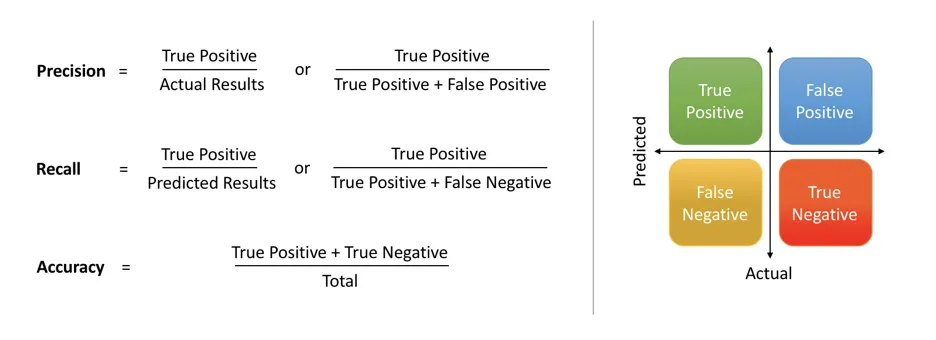

## 2. Data exploration

### 2.1 Data source 

Data for this assignment was found using <a href="https://www.kaggle.com/datasets/amoghmisra27/grocery/data">Kaggle</a>.

### 2.2 Get the data

In [167]:
# Loading datasets
classes = pd.read_csv('GroceryStoreDataset-master/dataset/classes.csv')
classes.head()

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
0,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Go...,/iconic-images-and-descriptions/Fruit/Apple/Go...
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
2,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pi...,/iconic-images-and-descriptions/Fruit/Apple/Pi...
3,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Re...,/iconic-images-and-descriptions/Fruit/Apple/Re...
4,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Ro...,/iconic-images-and-descriptions/Fruit/Apple/Ro...


### 2.3 Size and type of data
The dataset contains natural images of grocery items. All natural images were taken with a smartphone camera in different grocery stores. There are 5125 natural images from 81 different classes of fruits, vegetables, and carton items. The 81 classes are divided into 42 coarse-grained classes, where e.g. the fine-grained classes 'Royal Gala' and 'Granny Smith' belong to the same coarse-grained class 'Apple'.

The dataset contains images predominantly in JPEG format, with dimensions of 198x198 pixels, and utilizing the RGB color mode. These images are organized into subdirectories based on categories, such as "iconic" images representing the products. The consistent image size and format simplify preprocessing and model training, while the structured organization aids in efficient data management and category-specific analysis. 

The dataset is divided into three subsets: 

    Training Set: 2640 images 

    Validation Set: 296 images 

    Test Set: 2485 images 

This distribution of image samples introduces some concerns:
- Imbalanced data distribution: The model might not perform optimally due to an insufficiently large training set. Typically, the training set should be the largest portion of the data to allow the model to learn as comprehensively as possible.
- Overfitting or Underfitting: With a small validation set, there's a risk that the model's tuning is not reflective of its performance on a broader range of data, leading to overfitting (where the model learns the training data too well, including the noise and errors) or underfitting (where the model does not learn the underlying patterns effectively).
- Wasted Data on Testing: While it is good to have a comprehensive test to evaluate the model, the current allocation might be excessive. Reducing the test set and reallocating those images to the training set could provide more learning opportunities without significantly compromising the model’s evaluation.

Further in section 3, we will explore the image sample distribution within the categories and see how we can optimally redistribute the images.

## 3. Explore the data

1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

### 3.1 Create dataset copies

In [168]:
grocery_items_df = pd.DataFrame(classes)
display(grocery_items_df)

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
0,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Go...,/iconic-images-and-descriptions/Fruit/Apple/Go...
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
2,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pi...,/iconic-images-and-descriptions/Fruit/Apple/Pi...
3,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Re...,/iconic-images-and-descriptions/Fruit/Apple/Re...
4,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Ro...,/iconic-images-and-descriptions/Fruit/Apple/Ro...
...,...,...,...,...,...,...
76,Red-Beet,76,Red-Beet,40,/iconic-images-and-descriptions/Vegetables/Red...,/iconic-images-and-descriptions/Vegetables/Red...
77,Beef-Tomato,77,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...
78,Regular-Tomato,78,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...
79,Vine-Tomato,79,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...


### 3.2 Features and their characteristics

In [169]:
grocery_items_df.columns

Index(['Class Name (str)', 'Class ID (int)', 'Coarse Class Name (str)',
       'Coarse Class ID (int)', 'Iconic Image Path (str)',
       'Product Description Path (str)'],
      dtype='object')

In the output above, we can see that there are 6 features:
- Class Name (str) - e.g. 'Golden-Delicious', 'Pink-Lady'
- Class ID (int) - 0 to 80, as there are 81 classes
- Coarse Class Name (str) - e.g. 'Apple', 'Tomato' - category for each class
- Coarse Class ID (int) - 0 to 42, as there are 43 coarse classes
- Iconic Image Path (str) - file path to the picture in JPG format
- Product Description Path (str) - filepath to the grocery product's description in txt file

To make the features more understandable, we rename 'Coarse Class Name (str)' to 'Category Name (str)' and 'Coarse Class ID (int)' to 'Category ID (int)'


In [170]:
# rename column 'Coarse Class Name (str)' to 'Category Name'
grocery_items_df.rename(columns = {'Coarse Class Name (str)':'Category Name (str)'}, inplace = True)
grocery_items_df.rename(columns = {'Coarse Class ID (int)':'Category ID (int)'}, inplace = True)
display(grocery_items_df)

,Class Name (str),Class ID (int),Category Name (str),Category ID (int),Iconic Image Path (str),Product Description Path (str)
0,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Go...,/iconic-images-and-descriptions/Fruit/Apple/Go...
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
2,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pi...,/iconic-images-and-descriptions/Fruit/Apple/Pi...
3,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Re...,/iconic-images-and-descriptions/Fruit/Apple/Re...
4,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Ro...,/iconic-images-and-descriptions/Fruit/Apple/Ro...
...,...,...,...,...,...,...
76,Red-Beet,76,Red-Beet,40,/iconic-images-and-descriptions/Vegetables/Red...,/iconic-images-and-descriptions/Vegetables/Red...
77,Beef-Tomato,77,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...
78,Regular-Tomato,78,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...
79,Vine-Tomato,79,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...


To continue the data exploration, we will check how many items there are per category, to get a better understanding of the scope.

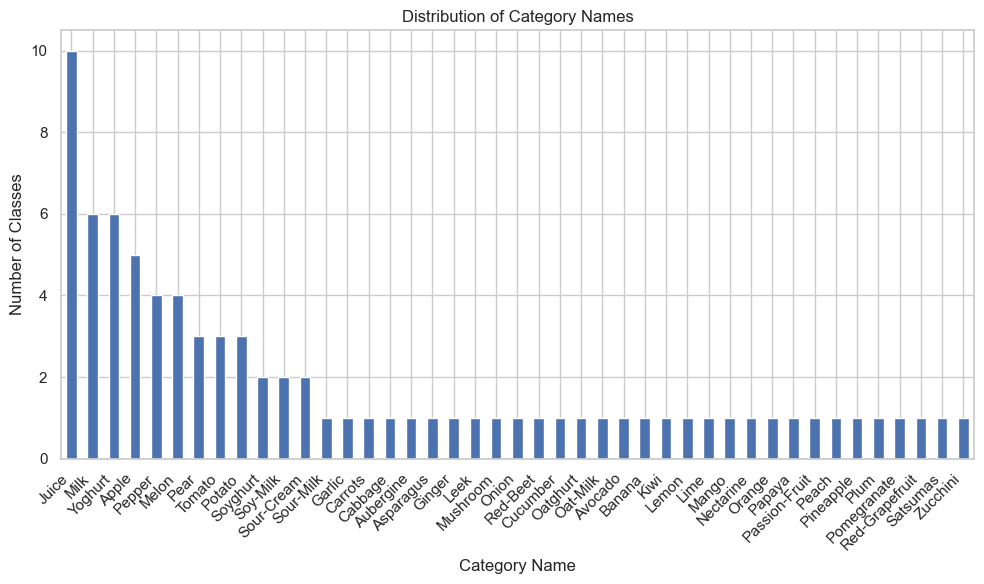

In [171]:
# Count the number of fine-grained classes in each coarse class
category_counts = grocery_items_df["Category Name (str)"].value_counts()

# Plot the distribution of classes in each category
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', title='Distribution of Category Names')
plt.xlabel('Category Name')
plt.ylabel('Number of Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Let's look at how many images there are per class in each train, test, and validation data set. To see this, we randomly choose a category - 'Juice', since it has the most classes.

In [172]:
train_file = 'GroceryStoreDataset-master/dataset/train.txt'
val_file = 'GroceryStoreDataset-master/dataset/val.txt'
test_file = 'GroceryStoreDataset-master/dataset/test.txt'

def count_images_by_classes(file_path, class_list):
    count = 0
    with open(file_path, 'r') as file:
        for line in file:
            image_path = line.strip().split()[0]
            if any(cls in image_path for cls in class_list):
                count += 1
    return count

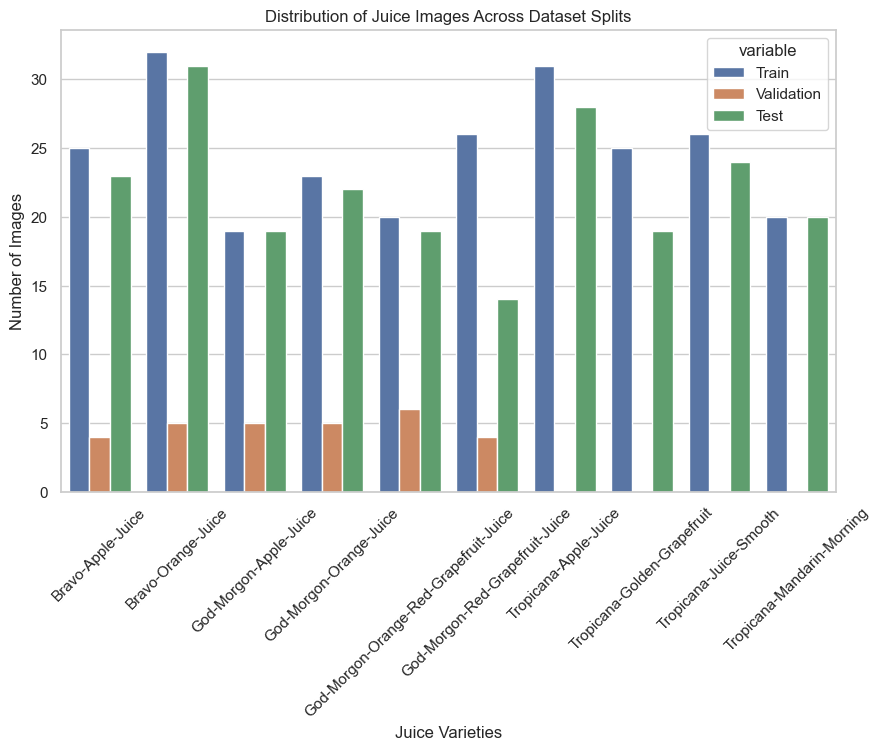

In [173]:
# Filtering for juice-related classes
juice_data = grocery_items_df[grocery_items_df['Category Name (str)'].str.contains("Juice", case=False, na=False)]

# Get unique classes of juices
juice_classes = juice_data['Class Name (str)'].unique()

# Prepare a DataFrame to hold the counts
columns = ['Juice Variety', 'Train', 'Validation', 'Test']
data = []

for juice in juice_classes:
    juice_list = juice_data[juice_data['Class Name (str)'].str.contains(juice, case=False, na=False)]['Class Name (str)'].tolist()

    # Count images for each dataset split
    train_count = count_images_by_classes(train_file, juice_list)
    val_count = count_images_by_classes(val_file, juice_list)
    test_count = count_images_by_classes(test_file, juice_list)

    data.append([juice, train_count, val_count, test_count])

juice_distribution_df = pd.DataFrame(data, columns=columns)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot data
plt.figure(figsize=(10, 6))
juice_plot = sns.barplot(x='Juice Variety', y='value', hue='variable', data=pd.melt(juice_distribution_df, ['Juice Variety']))

# Enhance plot aesthetics
juice_plot.set_title('Distribution of Juice Images Across Dataset Splits')
juice_plot.set_xlabel('Juice Varieties')
juice_plot.set_ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate class labels for better readability

# Show the plot
plt.show()



As we also observed in section 2.3, the image samples aren't optimally distributed, resulting in max 50% for the training set, 6% for the validation set, and 45% for the testing set. 
Our aim is:
- Training Set: About 70-80% of the data (ideally around 3795 to 4337 images).
- Validation Set: About 10-15% of the data (ideally around 542 to 813 images).
- Test Set: About 10-15% of the data (ideally around 542 to 813 images).

Therefore, we will redistribute the samples in each class to ensure following the 60/20/20 rule of dataset distribution.


Restribution of test, validation and train data

In [174]:
from collections import defaultdict
import random
import pandas as pd

all_classes = grocery_items_df['Class Name (str)'].tolist()

# Stratified reallocation function
def stratified_reallocate_splits(train_file, val_file, test_file, class_names, new_train_ratio=0.6, new_val_ratio=0.2, new_test_ratio=0.2):
    # Load the current splits
    with open(train_file, 'r') as f:
        train_data = f.readlines()
    with open(val_file, 'r') as f:
        val_data = f.readlines()
    with open(test_file, 'r') as f:
        test_data = f.readlines()

    # Combine all data
    all_data = train_data + val_data + test_data

    # Group data by categories
    category_data = defaultdict(list)
    for line in all_data:
        for class_name in class_names:
            if class_name in line:
                category_data[class_name].append(line)
                break

    # Create new splits
    new_train_data, new_val_data, new_test_data = [], [], []

    for category, items in category_data.items():
        random.shuffle(items)
        total = len(items)
        train_size = int(total * new_train_ratio)
        val_size = int(total * new_val_ratio)

        new_train_data.extend(items[:train_size])
        new_val_data.extend(items[train_size:train_size + val_size])
        new_test_data.extend(items[train_size + val_size:])

    # Save the new splits to files
    with open('new_train.txt', 'w') as f:
        f.writelines(new_train_data)
    with open('new_val.txt', 'w') as f:
        f.writelines(new_val_data)
    with open('new_test.txt', 'w') as f:
        f.writelines(new_test_data)

    return len(new_train_data), len(new_val_data), len(new_test_data)

# Apply stratified reallocation across all classes
new_train_count, new_val_count, new_test_count = stratified_reallocate_splits(
    train_file, val_file, test_file, all_classes, new_train_ratio=0.6, new_val_ratio=0.2, new_test_ratio=0.2
)

print(f"New Train Count: {new_train_count}")
print(f"New Validation Count: {new_val_count}")
print(f"New Test Count: {new_test_count}")

New Train Count: 3220
New Validation Count: 1055
New Test Count: 1146


Recalculate the distribution of each category in the new splits and compare it with the original distribution to ensure proportions are preserved.

In [175]:
from collections import Counter

# Function to count category occurrences in a file
def count_categories(split_file, class_names):
    category_counts = Counter()
    with open(split_file, 'r') as f:
        for line in f:
            for class_name in class_names:
                if class_name in line:
                    category_counts[class_name] += 1
                    break
    return category_counts

# Count categories in the new splits
new_train_category_counts = count_categories('new_train.txt', all_classes)
new_val_category_counts = count_categories('new_val.txt', all_classes)
new_test_category_counts = count_categories('new_test.txt', all_classes)

# Display the distributions
print("New Training Set Distribution:", new_train_category_counts)
print("New Validation Set Distribution:", new_val_category_counts)
print("New Test Set Distribution:", new_test_category_counts)

New Training Set Distribution: Counter({'Orange': 202, 'Satsumas': 85, 'Royal-Gala': 80, 'Granny-Smith': 73, 'Pink-Lady': 73, 'Red-Grapefruit': 70, 'Red-Delicious': 60, 'Watermelon': 58, 'Regular-Tomato': 58, 'Golden-Delicious': 57, 'Banana': 57, 'Kiwi': 57, 'Conference': 56, 'Carrots': 54, 'Vine-Tomato': 54, 'Lemon': 52, 'Avocado': 51, 'Cantaloupe': 50, 'Arla-Natural-Yoghurt': 49, 'Brown-Cap-Mushroom': 49, 'Yellow-Onion': 48, 'Peach': 46, 'Honeydew-Melon': 45, 'Anjou': 45, 'Garant-Ecological-Medium-Fat-Milk': 45, 'Arla-Medium-Fat-Milk': 43, 'Red-Bell-Pepper': 43, 'Galia-Melon': 42, 'Nectarine': 42, 'Yoggi-Strawberry-Yoghurt': 41, 'Oatly-Natural-Oatghurt': 40, 'Oatly-Oat-Milk': 40, 'Valio-Vanilla-Yoghurt': 40, 'Lime': 39, 'Mango': 39, 'Arla-Standard-Milk': 39, 'Zucchini': 38, 'Arla-Ecological-Medium-Fat-Milk': 37, 'Passion-Fruit': 36, 'Alpro-Blueberry-Soyghurt': 36, 'Alpro-Shelf-Soy-Milk': 36, 'Arla-Mild-Vanilla-Yoghurt': 36, 'Cucumber': 36, 'Sweet-Potato': 36, 'Kaiser': 35, 'Tropicana

Plotting the redestributed data on bar charts to visually compare category distributions across the splits

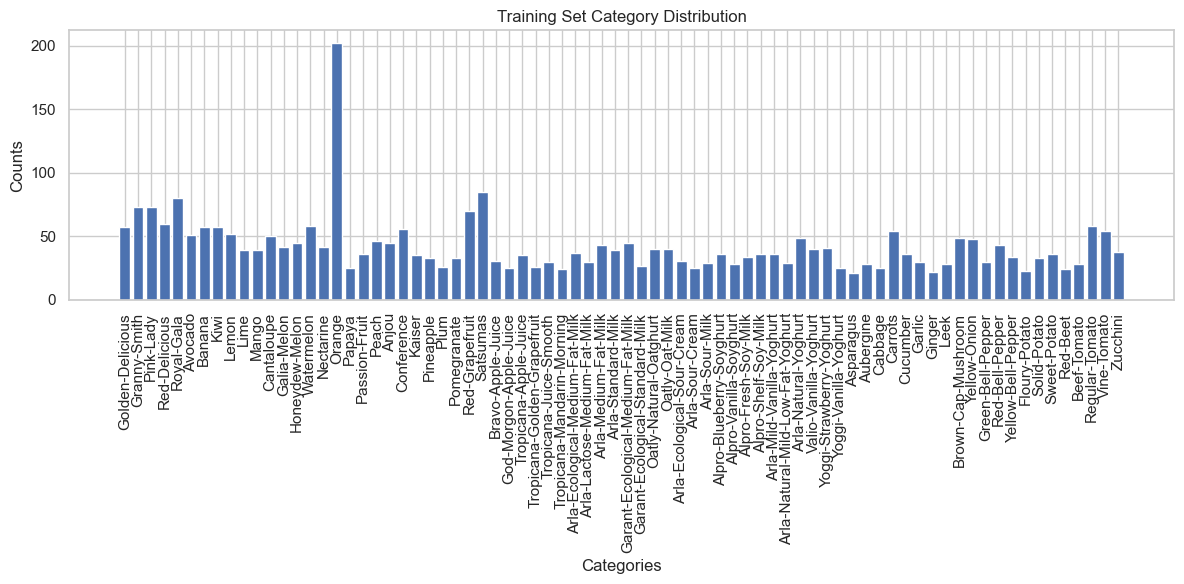

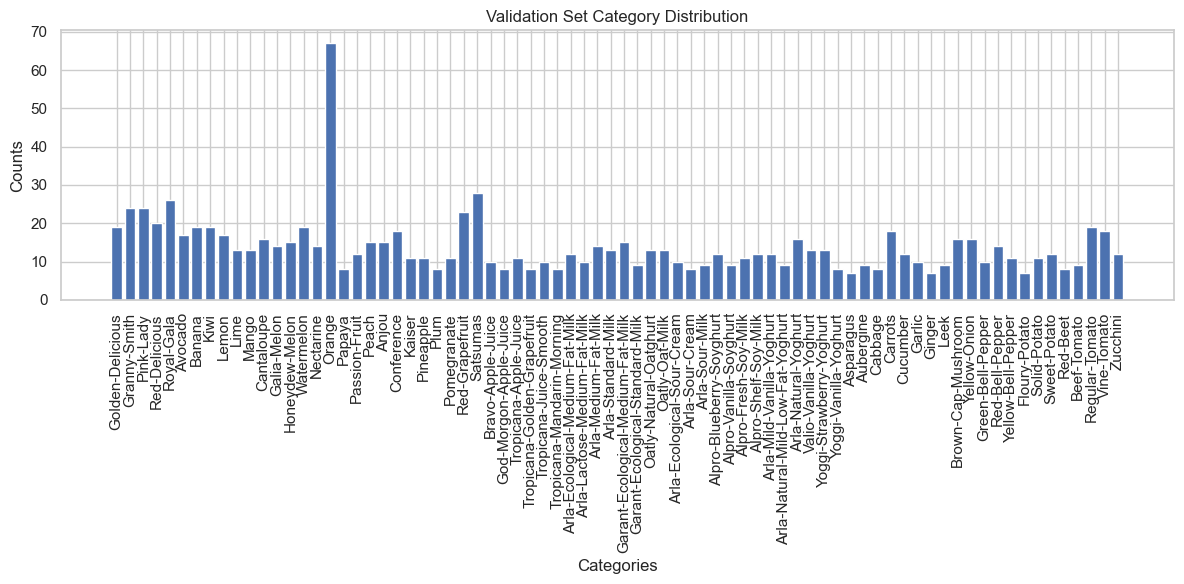

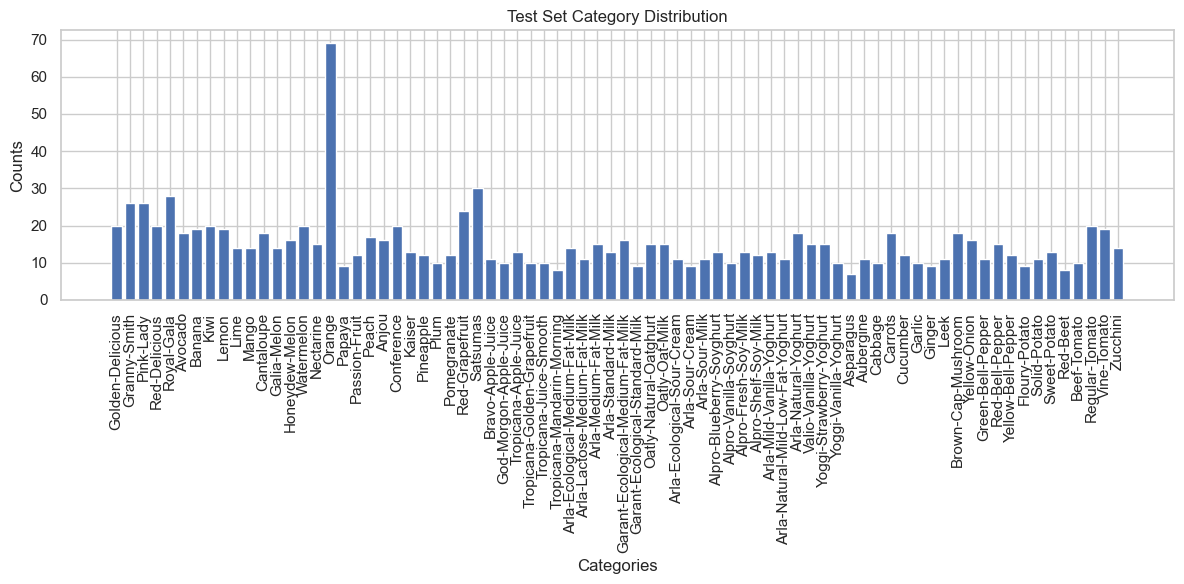

In [176]:
import matplotlib.pyplot as plt

# Function to visualize category distributions
def plot_category_distribution(category_counts, title):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    plt.figure(figsize=(12, 6))
    plt.bar(categories, counts)
    plt.title(title)
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot distributions for each split
plot_category_distribution(new_train_category_counts, 'Training Set Category Distribution')
plot_category_distribution(new_val_category_counts, 'Validation Set Category Distribution')
plot_category_distribution(new_test_category_counts, 'Test Set Category Distribution')

In [177]:
new_train_file = 'new_train.txt'
new_val_file = 'new_val.txt'
new_test_file = 'new_test.txt'

def count_images_by_classes_redistributed(file_path, class_list):
    count = 0
    with open(file_path, 'r') as file:
        for line in file:
            image_path = line.strip().split()[0]
            if any(cls in image_path for cls in class_list):
                count += 1
    return count

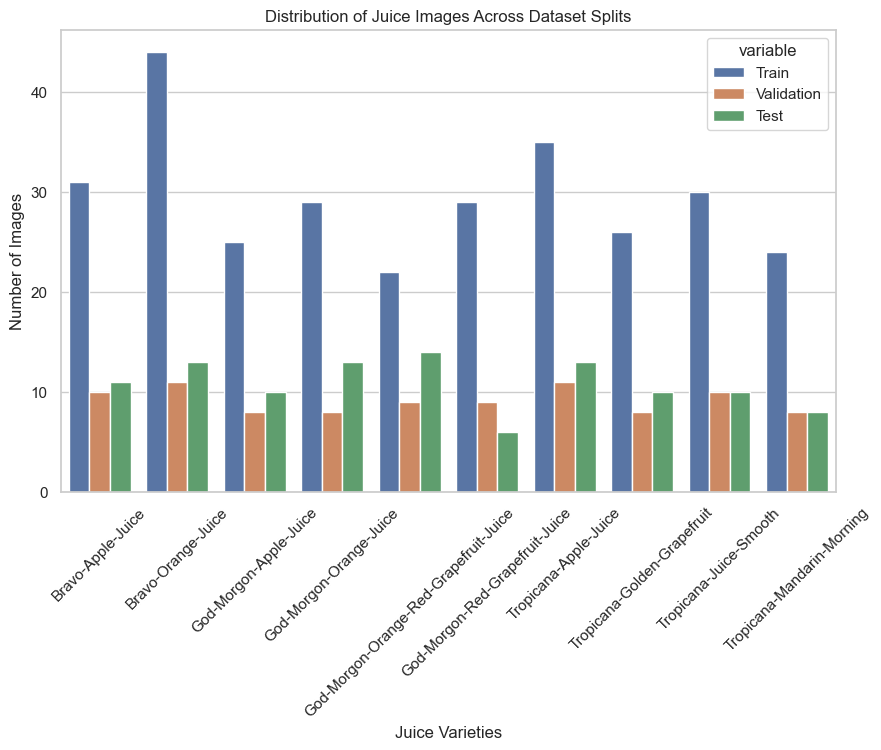

In [178]:
# Filtering for juice-related classes
juice_data = grocery_items_df[grocery_items_df['Category Name (str)'].str.contains("Juice", case=False, na=False)]

# Get unique classes of juices
juice_classes = juice_data['Class Name (str)'].unique()

# Prepare a DataFrame to hold the counts
columns = ['Juice Variety', 'Train', 'Validation', 'Test']
data = []

for juice in juice_classes:
    juice_list = juice_data[juice_data['Class Name (str)'].str.contains(juice, case=False, na=False)]['Class Name (str)'].tolist()

    # Count images for each dataset split
    new_train_count = count_images_by_classes_redistributed(new_train_file, juice_list)
    new_val_count = count_images_by_classes_redistributed(new_val_file, juice_list)
    new_test_count = count_images_by_classes_redistributed(new_test_file, juice_list)

    data.append([juice, new_train_count, new_val_count, new_test_count])

juice_distribution_df = pd.DataFrame(data, columns=columns)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot data
plt.figure(figsize=(10, 6))
juice_plot = sns.barplot(x='Juice Variety', y='value', hue='variable', data=pd.melt(juice_distribution_df, ['Juice Variety']))

# Enhance plot aesthetics
juice_plot.set_title('Distribution of Juice Images Across Dataset Splits')
juice_plot.set_xlabel('Juice Varieties')
juice_plot.set_ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate class labels for better readability

# Show the plot
plt.show()

Calculate the proportion of each category in each split and ensure they match the expected ratios:

In [179]:
# Calculate total counts for each split
total_train = sum(new_train_category_counts.values())
total_val = sum(new_val_category_counts.values())
total_test = sum(new_test_category_counts.values())

# Function to calculate proportions
def calculate_proportions(category_counts, total_count):
    return {category: count / total_count for category, count in category_counts.items()}

# Calculate proportions
train_proportions = calculate_proportions(new_train_category_counts, total_train)
val_proportions = calculate_proportions(new_val_category_counts, total_val)
test_proportions = calculate_proportions(new_test_category_counts, total_test)

# Print proportions
print("Proportions in Training Set:", train_proportions)
print("Proportions in Validation Set:", val_proportions)
print("Proportions in Test Set:", test_proportions)

Proportions in Training Set: {'Golden-Delicious': 0.017701863354037266, 'Granny-Smith': 0.02267080745341615, 'Pink-Lady': 0.02267080745341615, 'Red-Delicious': 0.018633540372670808, 'Royal-Gala': 0.024844720496894408, 'Avocado': 0.015838509316770187, 'Banana': 0.017701863354037266, 'Kiwi': 0.017701863354037266, 'Lemon': 0.016149068322981366, 'Lime': 0.012111801242236025, 'Mango': 0.012111801242236025, 'Cantaloupe': 0.015527950310559006, 'Galia-Melon': 0.013043478260869565, 'Honeydew-Melon': 0.013975155279503106, 'Watermelon': 0.018012422360248446, 'Nectarine': 0.013043478260869565, 'Orange': 0.06273291925465839, 'Papaya': 0.007763975155279503, 'Passion-Fruit': 0.011180124223602485, 'Peach': 0.014285714285714285, 'Anjou': 0.013975155279503106, 'Conference': 0.017391304347826087, 'Kaiser': 0.010869565217391304, 'Pineapple': 0.010248447204968944, 'Plum': 0.008074534161490683, 'Pomegranate': 0.010248447204968944, 'Red-Grapefruit': 0.021739130434782608, 'Satsumas': 0.026397515527950312, 'Br